<a href="https://colab.research.google.com/github/ctshiz/DEEP_LEARNING_STUDIES/blob/main/Extreme_Rare_Event_Classification_using_Autoencoders_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# All credits to Chitta Ranjan
# https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098

In [18]:
#import the desired libraries
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
tf.random.set_seed(2)

#used to help randomly select the data points
SEED = 123
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8,6
LABELS = ['Normal','Break']

In [3]:
#read and prepare the data
df = pd.read_csv("processminer-rare-event-mts - data.csv")

In [4]:
#count number of positive labels
pos= len(df[df['y']==1])
neg = len(df[df['y']==0])
tot = len(df)
print("Percentual of positive labels are :", (pos/tot)*100)
print("Percentual of negative labels are :", (neg/tot)*100)

Percentual of positive labels are : 0.6739863028590064
Percentual of negative labels are : 99.326013697141


In [5]:
sign = lambda x:(1,-1)[x<0]

def curve_shift(df, shift_by):
  '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''
  vector = df['y'].copy()
  for s in range(abs(shift_by)):
    tmp = vector.shift(sign(shift_by))
    tmp = tmp.fillna(0)
    vector += tmp
  labelcol = 'y'
  # add vector to the df
  df.insert(loc=0,column=labelcol+'tmp', value=vector)
  #remove the rows ewith labelcol == 1
  df = df.drop(df[df[labelcol]==1].index)
  # drop labelcol and rename the tmpo col as labelcol
  df = df.drop(labelcol, axis=1)
  df = df.rename(columns={labelcol+'tmp':labelcol})
  #make the labelcol binary
  df.loc[df[labelcol] > 0, labelcol] = 1
  return df

In [6]:
#remove time column, and the categorial columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [7]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

df_train_0 = df_train.loc[df['y']==0]
df_train_1 = df_train.loc[df['y']==1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y']==0]
df_valid_1 = df_valid.loc[df['y']==1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y']==0]
df_test_1 = df_test.loc[df['y']==1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [8]:
#Standardization
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis=1))


df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis=1))

In [9]:
#Autoencoder Classifier
#initialization
nb_epoch = 200
batch_size = 128
#num of predictor variables
input_dim = df_train_0_x_rescaled.shape[1]
encoding_dim = 32
hidden_dim = int(encoding_dim/2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation ='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()
                                                                                                    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 59)]              0         
                                                                 
 dense (Dense)               (None, 32)                1920      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 59)                1947      
                                                                 
Total params: 5,211
Trainable params: 5,211
Non-trainable par

In [10]:
#training
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

cp = ModelCheckpoint(filepath='autoencoder_classifier.h5',save_best_only=True, verbose=0)

tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph = True, write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(df_valid_0_x_rescaled,df_valid_0_x_rescaled),verbose=1,callbacks=[cp,tb]).history

Epoch 1/200
92/92 [==============================] - 2s 10ms/step - loss: 0.8785 - accuracy: 0.0472 - val_loss: 0.7359 - val_accuracy: 0.0602
Epoch 2/200
92/92 [==============================] - 1s 7ms/step - loss: 0.5571 - accuracy: 0.1072 - val_loss: 0.5029 - val_accuracy: 0.1538
Epoch 3/200
92/92 [==============================] - 1s 6ms/step - loss: 0.4187 - accuracy: 0.1832 - val_loss: 0.4144 - val_accuracy: 0.2269
Epoch 4/200
92/92 [==============================] - 1s 6ms/step - loss: 0.3518 - accuracy: 0.2501 - val_loss: 0.3627 - val_accuracy: 0.2823
Epoch 5/200
92/92 [==============================] - 1s 7ms/step - loss: 0.3127 - accuracy: 0.3032 - val_loss: 0.3296 - val_accuracy: 0.3161
Epoch 6/200
92/92 [==============================] - 1s 8ms/step - loss: 0.2867 - accuracy: 0.3284 - val_loss: 0.3068 - val_accuracy: 0.3599
Epoch 7/200
92/92 [==============================] - 1s 7ms/step - loss: 0.2672 - accuracy: 0.3517 - val_loss: 0.2877 - val_accuracy: 0.3739
Epoch 8/200


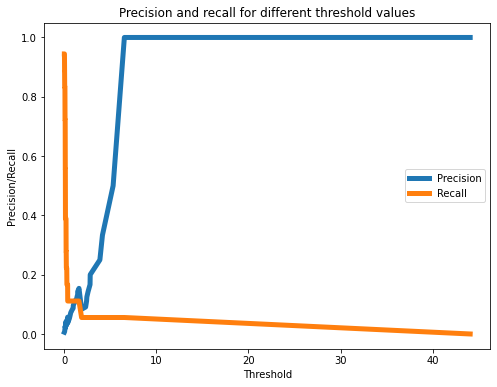

In [14]:
#classification
#if the reconstruction erro is high, classify as a sheet-break
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class':df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

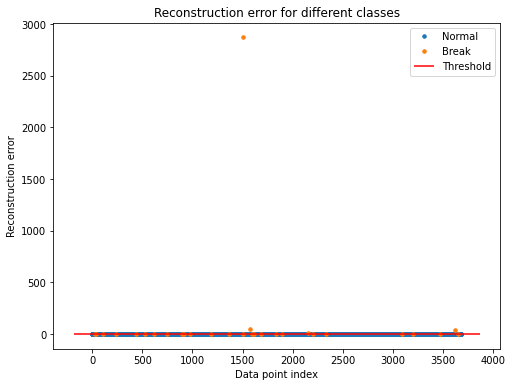

In [15]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error':mse, 'True_class':df_test['y']})
error_df_test = error_df_test.reset_index()

threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [16]:
#In Figure, the orange and blue dot above the threshold line represents the True Positive and False Positive, respectively.

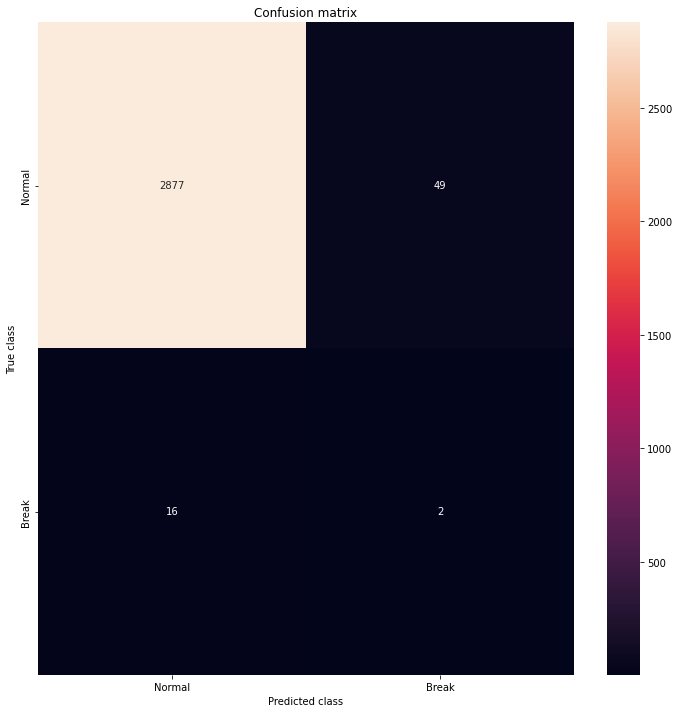

In [19]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

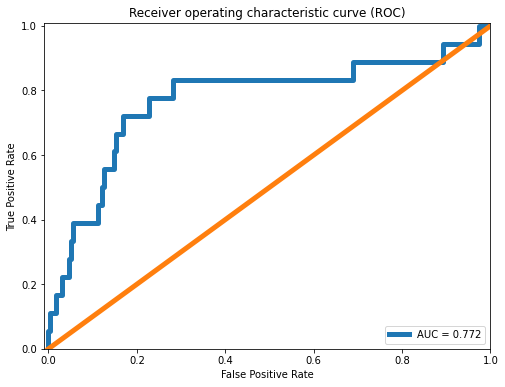

In [20]:
#ROC curve and AUC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()